# S3E25 Moh's Hardness Prediction EDA
* Predict Moh's hardness given physical parameters
* Regression Problem, try
    * Linear Regression Baseline
    * Lasso, Ridge
    * Support Vectors
    * Decision Trees
    * Random Forest
    * Gradient Boosting
    * ANN's (fastai tabular learner)


# Installs

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')


# Configuration

In [2]:
class Config:
    seed = 12
    folds = 5

In [3]:
config = Config()

# Load Data

In [4]:
kaggle = False

base_dir = '/kaggle/input/playground-series-s3e25' if kaggle else '.'
train = pd.read_csv(base_dir + '/train.csv')
test = pd.read_csv(base_dir + '/test.csv')
ss = pd.read_csv(base_dir + '/sample_submission.csv')


# Top Level Statistics

In [5]:
# print all sets - assuming train,test, ss
print(f'Training Data Shape: {train.shape}')
display(train.head())
print(f'Test Data Shape: {test.shape}')
display(test.head())
print(f'Sample Submission Shape: {ss.shape}')
display(ss.head())

Training Data Shape: (10407, 13)


,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


Test Data Shape: (6939, 12)


,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,10407,884.0,121.420000,35.36,5.28,82.561240,9.370384,2.298,1.9072,1.200000,0.461899,1.79459
1,10408,90.0,9.931960,18.00,5.60,39.568056,12.086300,2.868,1.6520,0.864000,0.476196,1.41194
2,10409,116.0,7.767992,11.60,4.80,23.231818,11.023840,2.644,1.7940,0.960000,0.499514,0.78834
3,10410,100.0,9.107996,10.00,4.80,20.298893,12.086300,2.828,1.6620,0.792000,0.495796,1.20466
4,10411,55.0,4.030000,11.00,4.00,22.977675,11.280950,2.455,1.7500,0.893333,0.476095,0.93456


Sample Submission Shape: (6939, 2)


,id,Hardness
0,10407,4.647
1,10408,4.647
2,10409,4.647
3,10410,4.647
4,10411,4.647


In [6]:
display(train.describe())
display(test.describe())

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.00000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,5203.00000,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,3004.38646,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2601.50000,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,5203.00000,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,7804.50000,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,10406.00000,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
count,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000
mean,13876.000000,126.460128,14.794020,17.406186,4.546852,38.422790,10.921512,2.608119,1.737907,0.949638,0.491675,2.152065
std,2003.261091,207.564499,18.982447,10.996089,0.683158,27.344351,1.378980,0.322873,0.190584,0.179266,0.060829,1.958213
min,10407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12141.500000,68.000000,7.558488,10.000000,4.000000,20.298893,10.584314,2.527500,1.678000,0.866667,0.476095,0.812440
50%,13876.000000,100.000000,10.650000,12.666667,4.750000,26.203827,11.202760,2.706000,1.736000,0.920000,0.488550,1.351550
75%,15610.500000,128.000000,16.601328,22.000000,4.800000,48.719500,11.645560,2.806667,1.820000,0.990000,0.496118,2.780220
max,17345.000000,10116.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615333,0.825990,10.970000


Todo: Look at percentage difference between train and test

In [7]:
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6939 entries, 0 to 6938
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     6939 non-null   int64  
 1   allelectrons_Total     6939 non-null   float64
 2   density_Total          6939 non-null   float64
 3   allelectrons_Average   6939 non-null   float64
 4   val_e_Average          6939 non-null   float64
 5   atomicweight_Average   6939 non-null   float64
 6   ionenergy_Average      6939 non-null   float64
 7   el_neg_chi_Average     6939 non-null   float64
 8   R_vdw_element_Average  6939 non-null   float64
 9   R_cov_element_Average  6939 non-null   float64
 10  zaratio_Average        6939 non-null   float64
 11  density_Average        6939 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 650.7 KB


None

### Takeaways
* Not a super huge dataset, 10K train, 7K test
* 10 features aside from id and 'hardness' in train as the target
* All floats except id
* No missing data

# EDA

## Distribution of Features

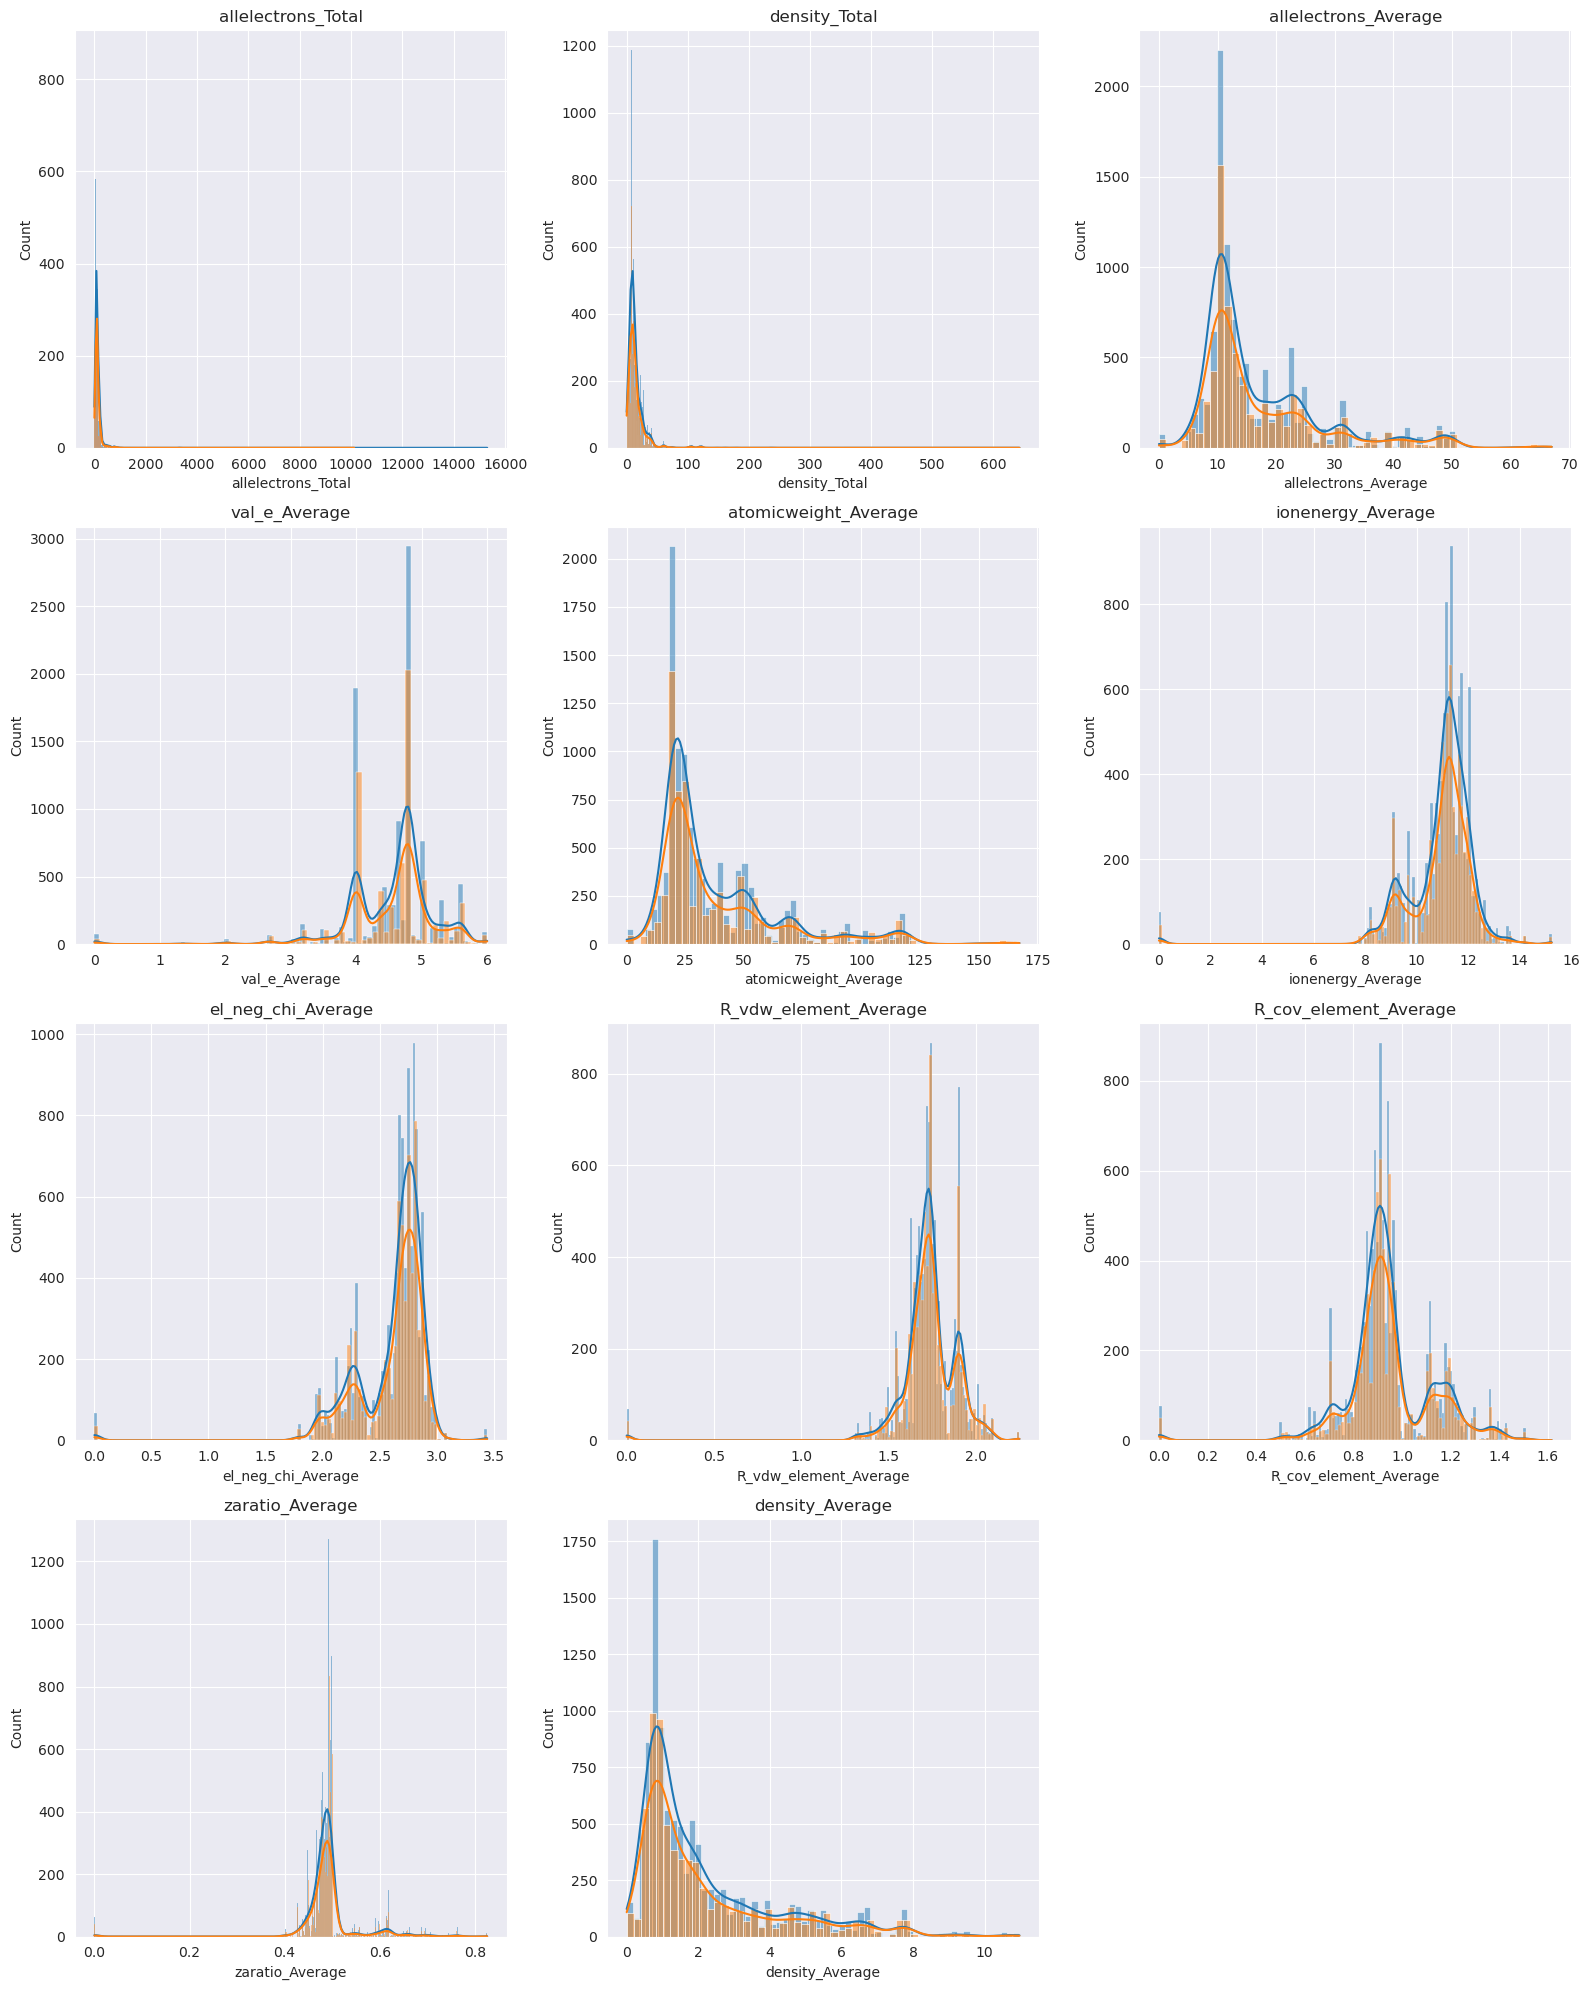

In [8]:
features = [col for col in test.columns if test[col].dtype == 'float']
rows = int(np.ceil(len(features) / 3))
plt.figure(figsize=(16, 5 * rows), tight_layout=True)
for i, col in enumerate(features):
    plt.subplot(rows, 3, i + 1)
    sns.histplot(train[col], kde=True)
    sns.histplot(test[col], kde=True)
    plt.title(col)

### Takeaways
* a few features have large outliers, need to investigate to see if should remove
* Some quite skewed, try log or sqrt transform
* Train and test look pretty similar, should be decent agreement between cv and lb

## Distribution of Target

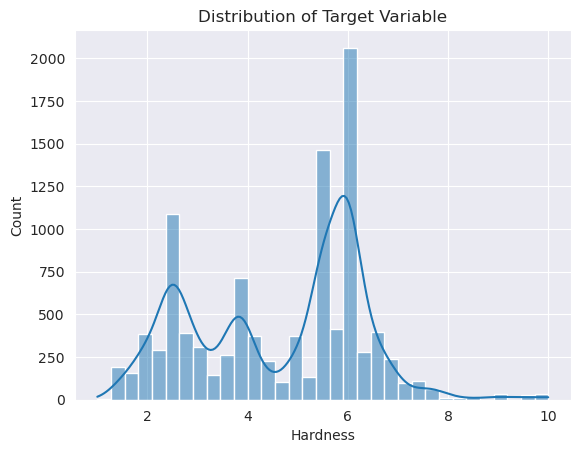

In [9]:
sns.histplot(train.Hardness, kde=True)
plt.title('Distribution of Target Variable')
plt.show()

## Correlation

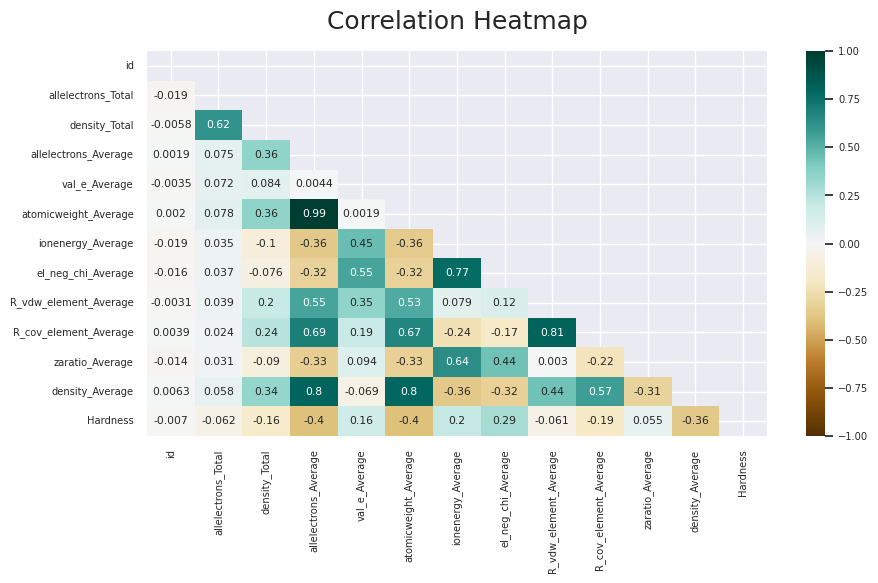

In [10]:
sns.set(font_scale=.65)
plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(train.corr(), dtype=bool))
heatmap = sns.heatmap(train.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 18}, pad=16);

### Takeaways
* There are some strongly correlated features
    * Try PCA

## Correlation with Target

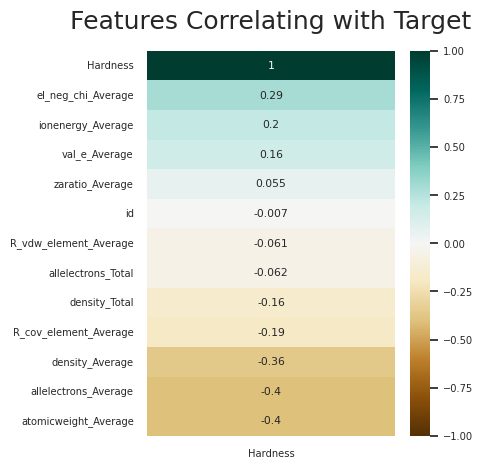

In [11]:
plt.figure(figsize=(4, 5))  # set size by num of features
heatmap = sns.heatmap(train.corr()[['Hardness']].sort_values(by='Hardness', ascending=False), vmin=-1, vmax=1,
                      annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Target', fontdict={'fontsize': 18}, pad=16);

### Takeways
* Seems like good signal
* look into dropping the 3 lower correlated ones

## Scatterplots with Target

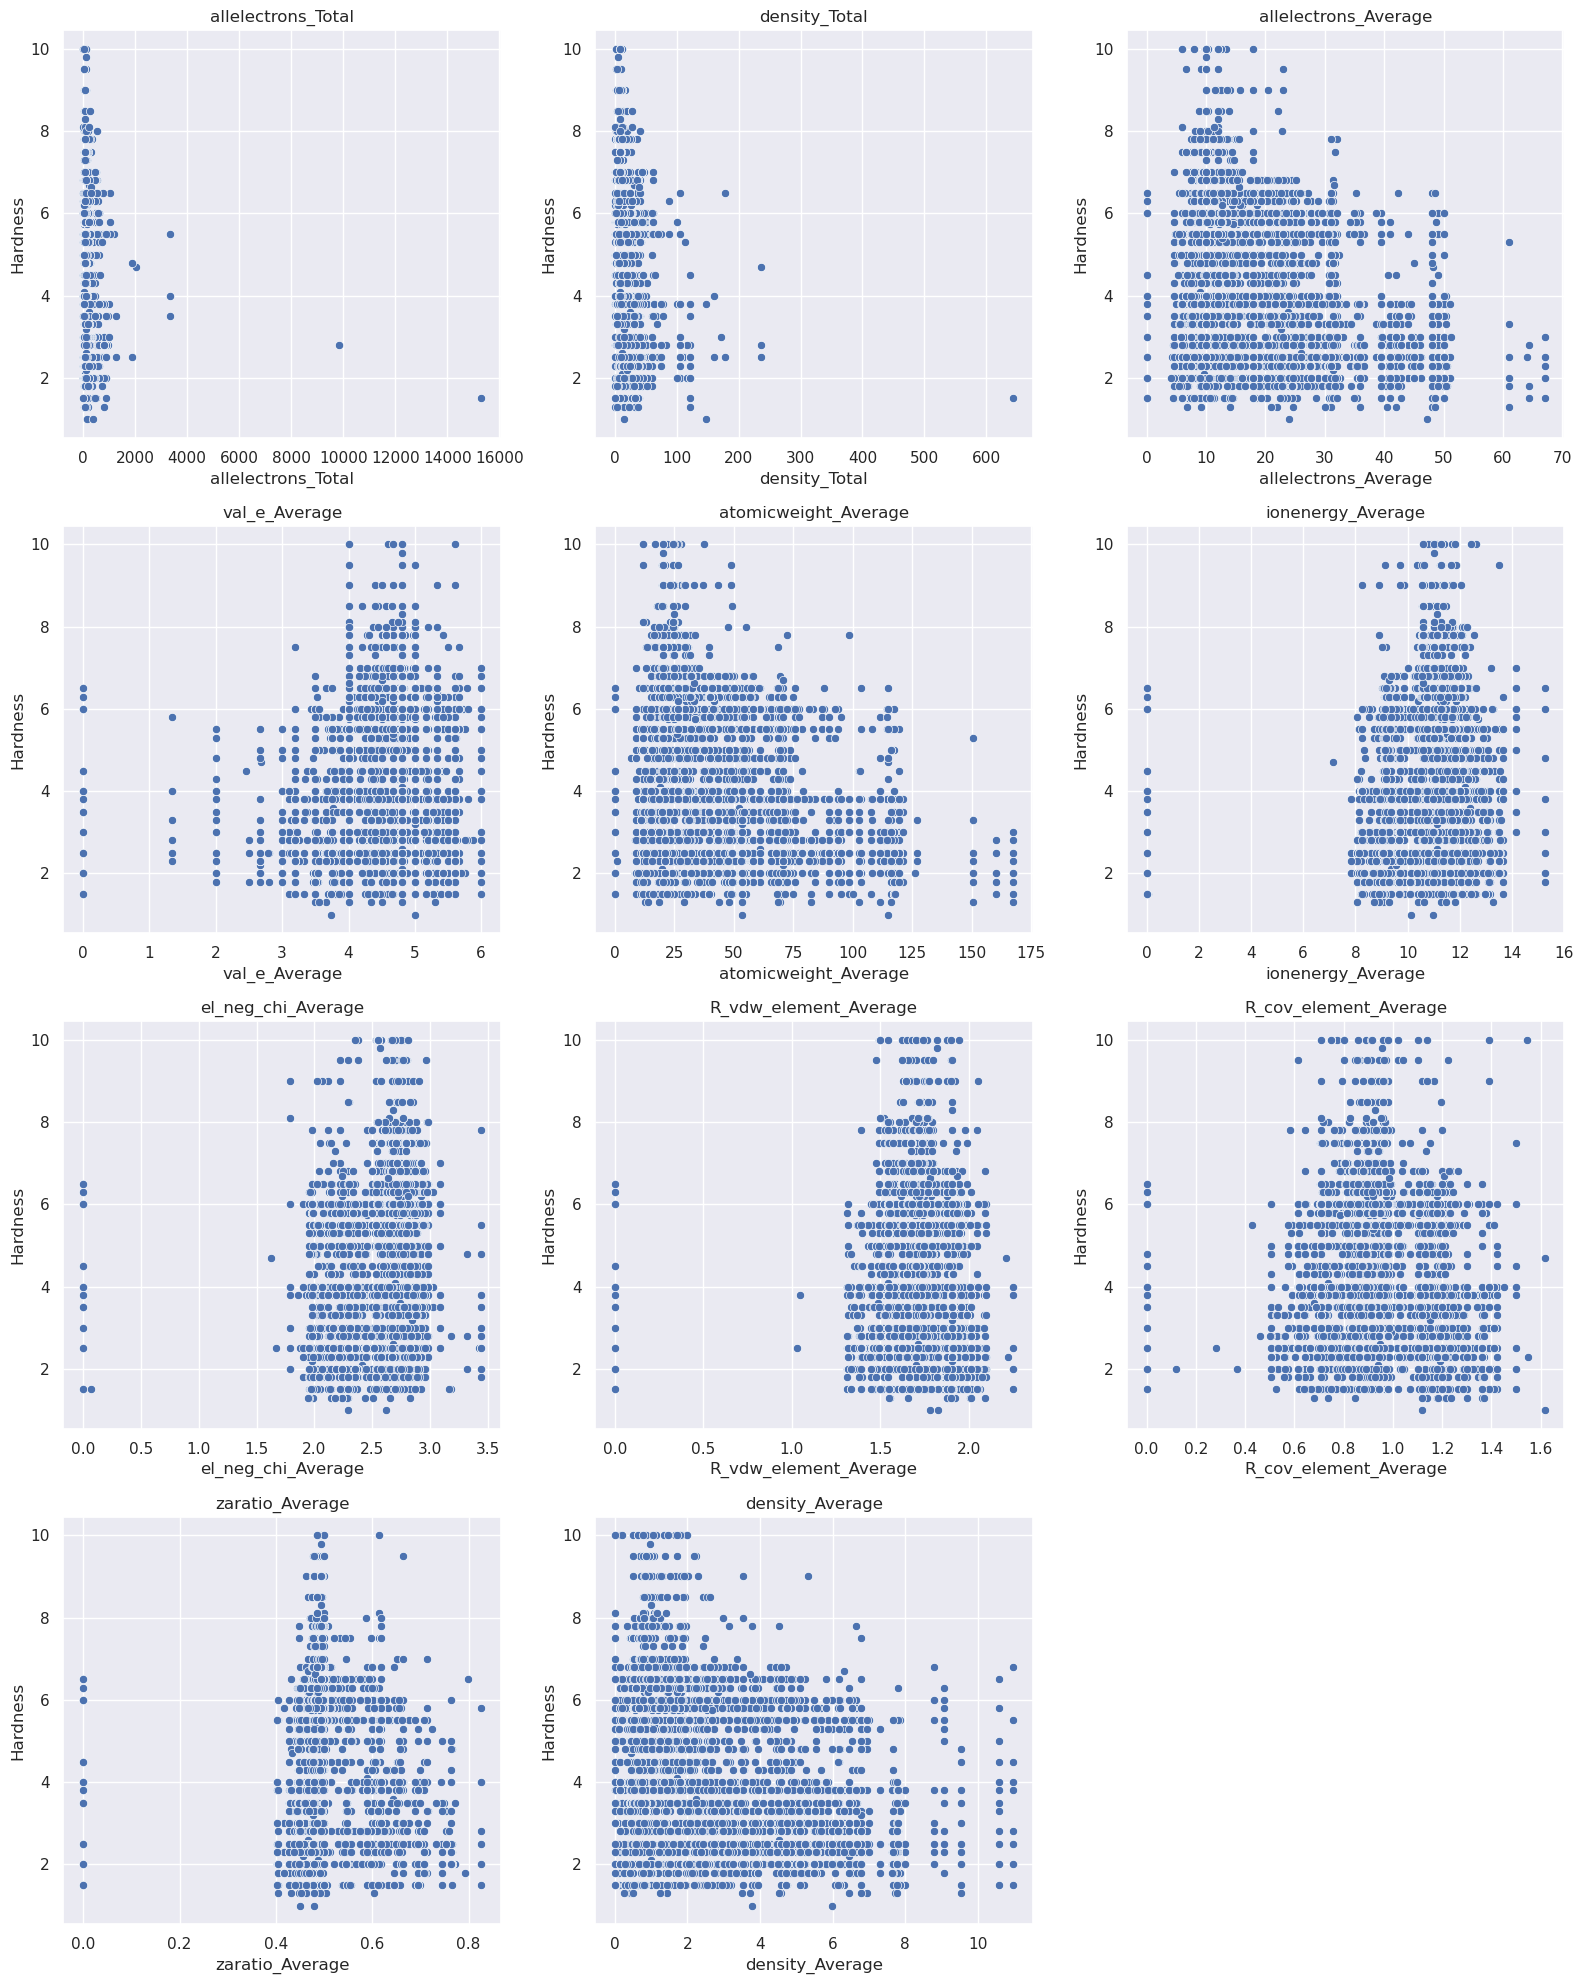

In [12]:
sns.set(font_scale=1.0)
features = [col for col in test.columns if test[col].dtype == 'float']
rows = int(np.ceil(len(features) / 3))
plt.figure(figsize=(16, 5 * rows), tight_layout=True)

for i, col in enumerate(features):
    plt.subplot(rows, 3, i + 1)
    sns.scatterplot(x=train[col], y=train.Hardness)
    plt.title(col)

### Takeaways
* how to deal with the zeros?
    * run experiment to determine if removing them helps

# Preprocesing

In [13]:
y = train.Hardness

# Cross Validation Functions

In [14]:
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import KFold


def run_cv_and_predict(train, test, features, model, seed, verbose=True):
    folds = config.folds
    # initialize arrays 
    fold_scores = []
    oof = np.zeros(train.shape[0])
    preds = np.zeros((test.shape[0], folds))

    # setup folding strategy
    skf = KFold(n_splits=folds, random_state=seed, shuffle=True)

    # start cross validation
    cur_fold = 1
    for trn_idx, val_idx in skf.split(train[features], y):

        # split indicies into train and validation
        x_train = train[features].iloc[trn_idx]
        y_train = y.iloc[trn_idx]
        x_valid = train[features].iloc[val_idx]
        y_valid = y.iloc[val_idx]

        # fit model
        model.fit(x_train, y_train)

        # predict on validation set
        fold_preds = model.predict(x_valid)
        #fold_preds = fold_preds.reshape(len(fold_preds)) # sbabwtdt
        oof[val_idx] = fold_preds

        # Compute scores
        fold_score = median_absolute_error(y_valid, fold_preds)  # CHOOSE METRIC HERE
        fold_scores.append(fold_score)
        if verbose:
            print(f'MAE Score, fold {cur_fold}: {fold_score}')

        # predict on test set - store all fold preds (take mode later)
        test_preds = model.predict(test[features])
        #test_preds = test_preds.reshape(len(test_preds))  # shouldn't have to do this.
        preds[:, cur_fold - 1] = test_preds
        cur_fold += 1

    # Print mean fold and oof score 
    oof_score = median_absolute_error(y, oof)
    # oof_score = np.sqrt(mean_squared_error(y,oof))
    print(f'MAE score: {np.mean(fold_scores):.5f}, Stdev: {np.std(fold_scores):.5f}, OOF score: {oof_score:.5f}')
    # print(f'RMSE score: {np.mean(scores):.5f}, Stdev: {np.std(scores):.5f}, OOF score: {oof_score:.5f}')

    return (preds, fold_scores, oof_score, oof)

# Models

## Linear Regression Baseline

In [15]:
from sklearn.linear_model import LinearRegression

# model_lr = LinearRegression()
# preds_lr,scores_lr,oof_score_lr,oof_lr = run_cv_and_predict(train,test,features,model_lr,config.seed)

# default cv = .96700, lb = .98495

## Lasso Regression

In [16]:
from sklearn.linear_model import Lasso

# model_lasso = Lasso()
# preds_lasso,scores_lasso,oof_score_lasso,oof_lasso = run_cv_and_predict(train,test,features,model_lasso,config.seed)

# default: MAE score: 1.08483, Stdev: 0.01510, OOF score: 1.08529
# how is this above 1?

## Ridge Regression

In [17]:
from sklearn.linear_model import Ridge

# model_svm = Ridge()
# preds_ridge,scores_ridge,oof_score_ridge,oof_ridge = run_cv_and_predict(train,test,features,model_ridge,config.seed)

#default: MAE score: 0.96897, Stdev: 0.01115, OOF score: 0.96980

## Support Vector Machines

In [18]:
# use SVR for regression, SVC for classfication
# from sklearn.svm import SVR #SVC, LinearSVC

# model_svm = SVR(kernel='linear')
# preds_svm,scores_svm,oof_score_svm,oof_svm = run_cv_and_predict(train,test,features,model_svm,config.seed)

# svm default with rbf kernel: MAE score: 0.88030, Stdev: 0.01481, OOF score: 0.88354, lb = crashed
# svm with linear kernel: MAE score: 0.82035, Stdev: 0.01722, OOF score: 0.82318, lb = 

## Decision Tree

In [19]:
from sklearn.tree import DecisionTreeRegressor

# values = []
# # optimize max depth
# for md in range(3,30):

model_dt = DecisionTreeRegressor(max_depth=15, random_state=config.seed)
preds_dt, scores_dt, oof_score_dt, oof_dt = run_cv_and_predict(train, test, features, model_dt, config.seed,
                                                               verbose=False)
#     values.append([md, np.mean(scores_dt)])


#max_depth 4: MAE score: 0.76808, Stdev: 0.05571, OOF score: 0.76048, 
# max depth 5: MAE score: 0.76159, Stdev: 0.02841, OOF score: 0.76522
# max depth 6: MAE score: 0.70609, Stdev: 0.03774, OOF score: 0.69927
# max depth 7: MAE score: 0.69753, Stdev: 0.00514, OOF score: 0.69643
# max depth 8: MAE score: 0.67461, Stdev: 0.02385, OOF score: 0.66893
# max depth 18: MAE score: 0.64324, Stdev: 0.07321, OOF score: 0.64942
# 28 is too high, optimizing 

# max depth 15 is min, MAE score: 0.63260, Stdev: 0.05069, OOF score: 0.62941, lb = .63083


MAE score: 0.63260, Stdev: 0.05069, OOF score: 0.62941


In [20]:
# md_df = pd.DataFrame(values,columns=['max_depth','cv_score'])
# plt.plot(md_df.max_depth,md_df.cv_score)
# plt.title(f'Max depth vs 5 fold cv score')
# plt.show()

#### Looks like best max_depth is around 15
* Review what other are good parameters to vary

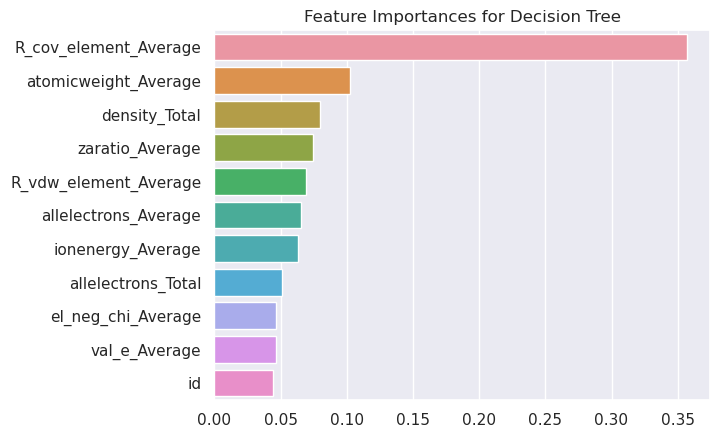

In [21]:
model_dt.feature_importances_
indices = np.argsort(model_dt.feature_importances_)[::-1]
g = sns.barplot(y=train.columns[indices], x=model_dt.feature_importances_[indices], orient='h')
plt.title('Feature Importances for Decision Tree');

## Random Forest

In [22]:
%%time
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=400, random_state=config.seed)
preds_rf, scores_rf, oof_score_rf, oof_rf = run_cv_and_predict(train, test, features, model_rf, config.seed,
                                                               verbose=False)

# Default rf, 100 est: MAE score: 0.65300, Stdev: 0.01621, OOF score: 0.65100
# 50 est: MAE score: 0.65800, Stdev: 0.01789, OOF score: 0.66000
# 200 est: MAE score: 0.65150, Stdev: 0.01323, OOF score: 0.65230
# 400 est: MAE score: 0.64783, Stdev: 0.01812, OOF score: 0.64700, lb = 

MAE score: 0.64783, Stdev: 0.01812, OOF score: 0.64700
CPU times: user 1min 14s, sys: 118 ms, total: 1min 14s
Wall time: 1min 14s


In [23]:
model_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12,
 'verbose': 0,
 'warm_start': False}

## Extra Trees

In [ ]:
%%time
# from sklearn.ensemble import ExtraTreesRegressor
# 
# model_etc = ExtraTreesRegressor(criterion='absolute_error',
#                                 n_estimators=200,
#                                 max_depth=12,
#                                 max_features=None,
#                                 n_jobs=4,
#                                 random_state=config.seed)
# 
# preds_etc, scores_etc, oof_score_etc, oof_etc = run_cv_and_predict(train, test, features, model_etc, config.seed,
#                                                                    verbose=True)

# default 100 est, MAE score: 0.65010, Stdev: 0.02108, OOF score: 0.65100, lb = 
# 200 est: MAE score: 0.65085, Stdev: 0.01528, OOF score: 0.65000, 
# default with criterion of absolute error. .66640 (worse)
# use new params from spreadsheet, 200 est, 12 md, max_features = None, cv = .54529


In [ ]:
model_etc.get_params()

# XGBoost

In [ ]:
%%time
# from xgboost import XGBRegressor
# 
# # results = []
# # for est in range(20,60):
# 
# model_xgb = XGBRegressor(n_estimators=46, random_state=config.seed)
# preds_xgb, scores_xgb, oof_score_xgb, oof_xgb = run_cv_and_predict(train, test, features, model_xgb, config.seed,
#                                                                    verbose=False)
#     results.append([est,np.mean(scores_xgb)])


# results = pd.DataFrame(results, columns=['estimators','score'])
# results.head()

# default: .67487
# 46 estimators: .65363

In [ ]:
#plt.plot(results.estimators,results.score)

First run looks like 46 estimator is min

### Takeways
* Seems to like lower estimator values
* do a 3 way grid opimization next

## Catboost

In [24]:
%%time
from catboost import CatBoostRegressor

results = []
for est in [100, 200, 300, 400, 500, 750, 1000]:
    for md in [3, 4, 5, 6, 7, 8, 10, 12, 14]:
        for lr in [.01, .02, .03, .04, .05, .06, .08, .1]:
            model_cat = CatBoostRegressor(random_state=config.seed,
                                          verbose=0,
                                          eval_metric='MAE',
                                          n_estimators=est,
                                          max_depth=md,
                                          learning_rate=lr
                                          )  # maybe quantile for eval metric

            print(f'est: {est},max depth: {md}, learning rate: {lr}')
            preds_cat, scores_cat, oof_score_cat, oof_cat = run_cv_and_predict(train, test, features, model_cat,
                                                                               config.seed, verbose=False)
            results.append([est, md, lr, np.mean(scores_cat)])


# default :.65412
# something not right, scores seem like MSE not MAE

est: 100,max depth: 3, learning rate: 0.01
MAE score: 1.09099, Stdev: 0.01655, OOF score: 1.09175
est: 100,max depth: 3, learning rate: 0.02
MAE score: 0.90004, Stdev: 0.02018, OOF score: 0.90281
est: 100,max depth: 3, learning rate: 0.03
MAE score: 0.81827, Stdev: 0.01133, OOF score: 0.81900
est: 100,max depth: 3, learning rate: 0.04
MAE score: 0.79134, Stdev: 0.01340, OOF score: 0.79137
est: 100,max depth: 3, learning rate: 0.05
MAE score: 0.77249, Stdev: 0.01614, OOF score: 0.77239
est: 100,max depth: 3, learning rate: 0.06
MAE score: 0.75793, Stdev: 0.01717, OOF score: 0.75883
est: 100,max depth: 3, learning rate: 0.08
MAE score: 0.73964, Stdev: 0.01806, OOF score: 0.73992
est: 100,max depth: 3, learning rate: 0.1
MAE score: 0.73853, Stdev: 0.02243, OOF score: 0.73674
est: 100,max depth: 4, learning rate: 0.01
MAE score: 1.07376, Stdev: 0.01015, OOF score: 1.07487
est: 100,max depth: 4, learning rate: 0.02
MAE score: 0.87599, Stdev: 0.01440, OOF score: 0.87566
est: 100,max depth: 4

KeyboardInterrupt: 

In [26]:
results_df = pd.DataFrame(results, columns=['estimators', 'max_depth', 'learning_rate', 'cv_score'])
results_df.head()

,estimators,max_depth,learning_rate,cv_score
0,100,3,0.01,1.090991
1,100,3,0.02,0.900036
2,100,3,0.03,0.818275
3,100,3,0.04,0.791341
4,100,3,0.05,0.772485


In [ ]:
model_cat.get_all_params()

## Prediction Selection

In [ ]:
final_preds = np.mean(preds_xgb, axis=1)

# for svm, goes negative, clamp to zero
final_preds[final_preds < 0.0] = 0.0
final_preds[final_preds > 10.0] = 10.0

# Submission

In [ ]:
ss.Hardness = final_preds
ss.to_csv('submission.csv', index=False)
ss.head()

In [ ]:
plt.hist(ss.Hardness, bins=30);